## Cycle GAN Implementation

Based on the paper: <i>Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks</i>. There is a good reference [here](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/).

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D,Embedding
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose,Concatenate
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy,MSE,MAE
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from PIL import Image
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [2]:
# sketches-to-colored dataset:
x = np.load("./data/real_lg.npy") # images already scaled
x = np.vstack([x[:,0:128,0:128],x[:,0:128,128:256],x[:,128:256,0:128],x[:,128:256,128:256]])
y = np.load("./data/map_lg.npy")
y = np.vstack([y[:,0:128,0:128],y[:,0:128,128:256],y[:,128:256,0:128],y[:,128:256,128:256]])
y = shuffle(y,random_state=0) # shuffling images to ensure they are unpaired
print(x.shape,y.shape)

(16800, 128, 128, 3) (16800, 128, 128, 3)


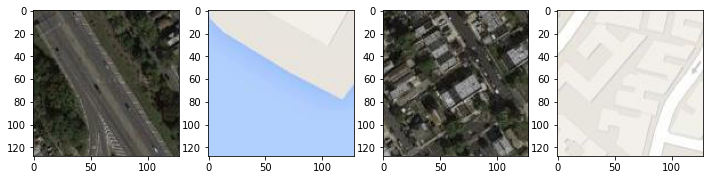

In [3]:
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(((x[0]*127.5)+127.5).astype("int32"))
plt.subplot(1,4,2)
plt.imshow(((y[0]*127.5)+127.5).astype("int32"))
plt.subplot(1,4,3)
plt.imshow(((x[1]*127.5)+127.5).astype("int32"))
plt.subplot(1,4,4)
plt.imshow(((y[1]*127.5)+127.5).astype("int32"))
plt.show()

### Model Implementation

In [4]:
def gen_resnet_block(h_in,n_channels=256):
    """ generator resnet block
        -comprised of 2 conv. blocks
    """
    h = Conv2D(filters=n_channels,kernel_size=3,padding='same',activation=None)(h_in)
    h = InstanceNormalization(axis=-1)(h)
    h = Activation('relu')(h)
    h = Conv2D(filters=n_channels,kernel_size=3,padding='same',activation=None)(h)
    h = InstanceNormalization(axis=-1)(h)
    h = Activation('relu')(h)
    h = Concatenate()([h,h_in]) # concatenate along channel dim.
    return h

In [5]:
def get_generator(n_resnet_blocks=6):
    """ generator implementation
    """
    source_img = Input(shape=(128,128,3))
    
    # downsampling:
    d = Conv2D(filters=64,kernel_size=5,padding='same',activation=None)(source_img) # 128x128
    d = InstanceNormalization(axis=-1)(d)
    d = Activation('relu')(d)
    d = Conv2D(filters=128,kernel_size=3,strides=2,padding='same',activation=None)(d) # 64x64
    d = InstanceNormalization(axis=-1)(d)
    d = Activation('relu')(d)
    d = Conv2D(filters=256,kernel_size=3,strides=2,padding='same',activation=None)(d) # 32x32
    d = InstanceNormalization(axis=-1)(d)
    h = Activation('relu')(d)
    
    # resnet blocks:
    for _ in range(n_resnet_blocks):
        h = gen_resnet_block(h)
        
    # upsampling:
    u = UpSampling2D()(h)
    u = Conv2D(filters=128,kernel_size=3,padding='same',activation=None)(u) # 64x64
    u = InstanceNormalization(axis=-1)(u)
    u = Activation('relu')(u)
    u = UpSampling2D()(u)
    u = Conv2D(filters=64,kernel_size=3,padding='same',activation=None)(u) # 128x128
    u = InstanceNormalization(axis=-1)(u)
    u = Activation('relu')(u)
    u = Conv2D(filters=3,kernel_size=5,padding='same',activation=None)(u) # 128x128
    out = Activation('tanh')(u)
    
    model = Model(inputs=source_img,outputs=out)
    return model

In [6]:
# note: these can be condensed into individual Keras models rather than having a custom training func.
@tf.function
def train_generator_1(generator,other_generator,optimizer,discriminator,target_x,source_x,adv_y,identity_lam=5,cycle_lam=10):
    """ used to train first generator
        -three loss components: L_identity,L_adversarial,L_cycle
    args:
        generator: the generator to train
        other_generator: fixed other-domain generator
        optimizer: optimizer for generator
        discriminator: discriminator for this domain
        source_x,target_x: examples from source and target distributions (from the perspective of this generator)
        adv_y: flipped labels used for L_adversarial
        identity_lam,cycle_lam: loss weights for L_identity,L_cycle
    """
    with tf.GradientTape() as tape:
        # L_adversarial component:
        adv_gen = generator(source_x)
        disc_pred = discriminator(adv_gen)
        adversarial_loss = discriminator_loss(adv_y,disc_pred)
        
        # L_identity component:
        identity_gen = generator(target_x) # we expect generator to produce identity
        identity_loss = identity_lam*tf.reduce_mean(MAE(target_x,identity_gen))
        
        # L_cycle component:
        left_cycle_loss = tf.reduce_mean(MAE(source_x,other_generator(generator(source_x))))
        right_cycle_loss = tf.reduce_mean(MAE(target_x,generator(other_generator(target_x))))
        cycle_loss = cycle_lam*(1/2)*(left_cycle_loss+right_cycle_loss)
        
        # full loss:
        loss = adversarial_loss+identity_loss+cycle_loss
    
    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

@tf.function
def train_generator_2(generator,other_generator,optimizer,discriminator,target_x,source_x,adv_y,identity_lam=5,cycle_lam=10):
    """ used to train second generator
    """
    with tf.GradientTape() as tape:
        # L_adversarial component:
        adv_gen = generator(source_x)
        disc_pred = discriminator(adv_gen)
        adversarial_loss = discriminator_loss(adv_y,disc_pred)
        # L_identity component:
        identity_gen = generator(target_x) # we expect generator to produce identity
        identity_loss = identity_lam*tf.reduce_mean(MAE(target_x,identity_gen))
        # L_cycle component:
        left_cycle_loss = tf.reduce_mean(MAE(source_x,other_generator(generator(source_x))))
        right_cycle_loss = tf.reduce_mean(MAE(target_x,generator(other_generator(target_x))))
        cycle_loss = cycle_lam*(1/2)*(left_cycle_loss+right_cycle_loss)
        # full loss:
        loss = adversarial_loss+identity_loss+cycle_loss
    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

In [7]:
def get_discriminator():
    """ discriminator implementation
        -PatchGAN with linear output
    """
    img = Input(shape=(128,128,3)) # determining if real or fake
    
    h = Conv2D(64,kernel_size=4,strides=2,padding='same')(img)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(128,kernel_size=4,strides=2,padding='same')(h)
    h = InstanceNormalization(axis=-1)(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(256,kernel_size=4,strides=2,padding='same')(h) # 16x16
    h = InstanceNormalization(axis=-1)(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(512,kernel_size=4,strides=2,padding='same')(h) # 8x8
    h = InstanceNormalization(axis=-1)(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(1,kernel_size=4,strides=1,padding='same')(h) # linear output
    
    model = Model(inputs=img,outputs=h)
    return model

In [8]:
def discriminator_loss(y_true,y_pred):
    """ custom discriminator loss
    """
    y_pred = Flatten()(y_pred) # Nx64
    disc_loss = tf.reduce_mean(MSE(y_true,y_pred))
    return disc_loss

In [9]:
def discriminator_model(discriminator,optimizer):
    """ compiling discriminator model
    """
    img = Input(shape=(128,128,3))
    out = discriminator(img)
    
    model = Model(inputs=img,outputs=out)
    model.compile(loss=discriminator_loss,loss_weights=[0.5],optimizer=optimizer)
    return model

In [10]:
# gen_1 converts source->target
d_1 = get_discriminator()
discriminator_1 = discriminator_model(d_1,optimizer=Adam(lr=0.0002,beta_1=0.5))
generator_1 = get_generator()

# gen_2 converts target->source
d_2 = get_discriminator()
discriminator_2 = discriminator_model(d_2,optimizer=Adam(lr=0.0002,beta_1=0.5))
generator_2 = get_generator()

### Model Training

The noise prior z~N(0,1)

In [ ]:
num_epochs=100
batch_size=20
gen_1_cache=None # stores most-recently generated images
gen_2_cache=None
gen_1_optimizer = Adam(lr=0.0002,beta_1=0.5)
gen_2_optimizer = Adam(lr=0.0002,beta_1=0.5)
disc_y = np.vstack([np.ones((batch_size//2,64)),np.zeros((batch_size//2,64))]).astype("float32") # 1:real, 0:fake
adv_y = np.ones((batch_size,64)).astype("float32")

for epoch_i in range(num_epochs): # number of epochs
    all_a1_losses = []
    all_a2_losses = []
    all_d1_losses = []
    all_d2_losses = []
    print("Epoch {}:".format(epoch_i+1))
    
    for i in range(0,len(x)-batch_size,batch_size):
        source_x = x[i:i+batch_size] # source images
        target_x = y[i:i+batch_size] # target images
        
        # ---training the discriminators:
        # discriminator_1 (source->target):
        discriminator_1.trainable=True
        gen_1_x = generator_1(source_x).numpy()
        disc_x = gen_1_x.copy()
        if gen_1_cache is not None: # utilizing some older generated images
            disc_x = np.vstack([disc_x[0:batch_size//4],gen_1_cache[0:batch_size//4]])
        else:
            disc_x = disc_x[0:batch_size//2]
        disc_x = np.vstack([target_x[0:batch_size//2],disc_x])
        d1_loss = discriminator_1.train_on_batch(disc_x,disc_y)
        all_d1_losses.append(float(d1_loss))
        gen_1_cache=gen_1_x # update with the most recent generated image
        
        # discriminator_2 (target->source):
        discriminator_2.trainable=True
        gen_2_x = generator_2(target_x).numpy()
        disc_x = gen_2_x.copy()
        if gen_2_cache is not None:
            disc_x = np.vstack([disc_x[0:batch_size//4],gen_2_cache[0:batch_size//4]])
        else:
            disc_x = disc_x[0:batch_size//2]
        disc_x = np.vstack([source_x[0:batch_size//2],disc_x])
        d2_loss = discriminator_2.train_on_batch(disc_x,disc_y)
        all_d2_losses.append(float(d2_loss))
        gen_2_cache=gen_2_x
        
        # ---training the generators:
        # generator_1 (source->target):
        generator_1.trainable=True
        generator_2.trainable=False
        discriminator_1.trainable=False
        g1_loss = train_generator_1(generator_1,generator_2,gen_1_optimizer,discriminator_1,target_x,source_x,adv_y)
        all_a1_losses.append(float(g1_loss))
        
        # generator_2 (target->source):
        generator_2.trainable=True
        generator_1.trainable=False
        discriminator_2.trainable=False
        g2_loss = train_generator_2(generator_2,generator_1,gen_2_optimizer,discriminator_2,source_x,target_x,adv_y)
        all_a2_losses.append(float(g2_loss))
        
        if i%2000 == 0:
            for l in [0,2]:
                plt.figure(figsize=(15,4))
                for j in range(2):
                    k = j+l
                    # displaying the input and output:
                    this_source_x = ((source_x[k]*127.5)+127.5).astype("int32") 
                    this_gen_1 = ((generator_1(np.expand_dims(source_x[k],axis=0)).numpy()*127.5)+127.5).astype("int32")[0]
                    this_target_x = ((target_x[k]*127.5)+127.5).astype("int32")
                    this_gen_2 = ((generator_2(np.expand_dims(target_x[k],axis=0)).numpy()*127.5)+127.5).astype("int32")[0]
                    plt.subplot(1,8,j*4+1)
                    plt.imshow(this_source_x)
                    plt.subplot(1,8,j*4+2)
                    plt.imshow(this_gen_1)
                    plt.subplot(1,8,j*4+3)
                    plt.imshow(this_target_x)
                    plt.subplot(1,8,j*4+4)
                    plt.imshow(this_gen_2)
                plt.show()
            print("--------------")
            
    print("gen_1 loss:{}; gen_2 loss:{}; disc_1 loss:{}; disc_2 loss:{}".format(sum(all_a1_losses)/len(all_a1_losses),sum(all_a2_losses)/len(all_a2_losses),sum(all_d1_losses)/len(all_d1_losses),sum(all_d2_losses)/len(all_d2_losses)))            
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")

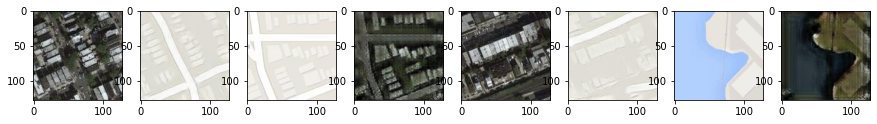

In [13]:
l=0
plt.figure(figsize=(15,4))
for j in range(2):
    k = j+l
    # displaying the input and output:
    this_source_x = ((x[k]*127.5)+127.5).astype("int32") 
    this_gen_1 = ((generator_1(np.expand_dims(x[k],axis=0)).numpy()*127.5)+127.5).astype("int32")[0]
    this_target_x = ((y[k]*127.5)+127.5).astype("int32")
    this_gen_2 = ((generator_2(np.expand_dims(y[k],axis=0)).numpy()*127.5)+127.5).astype("int32")[0]
    plt.subplot(1,8,j*4+1)
    plt.imshow(this_source_x)
    plt.subplot(1,8,j*4+2)
    plt.imshow(this_gen_1)
    plt.subplot(1,8,j*4+3)
    plt.imshow(this_target_x)
    plt.subplot(1,8,j*4+4)
    plt.imshow(this_gen_2)
plt.show()

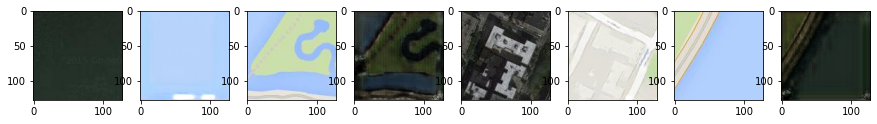

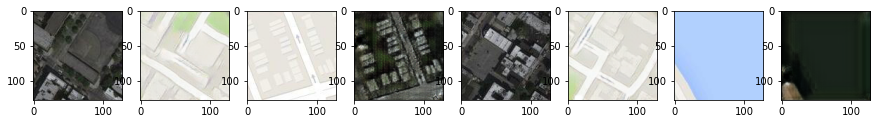

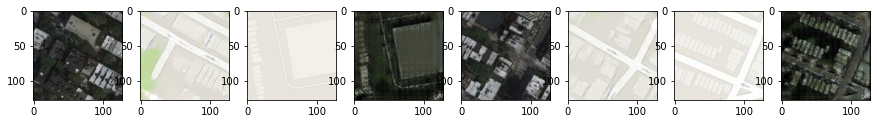

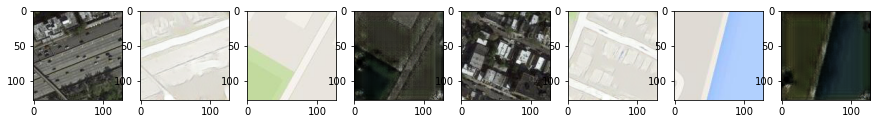

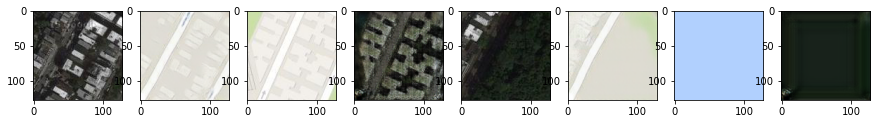

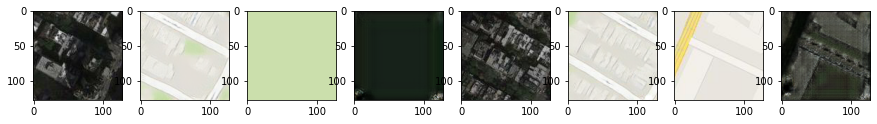

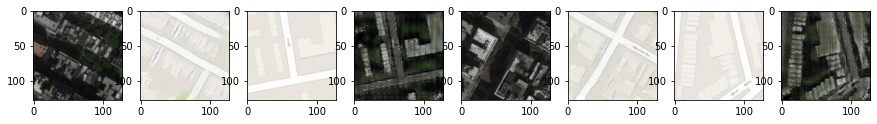